### 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
path = '/Users/timovic/Desktop/Climate Analysis - battle station/02 Data'

In [3]:
df = pd.read_pickle(os.path.join(path, 'Prepared Data', 'merged_all.pkl'))

In [4]:
df.head()

,country,year,hdi,gni,co2_consumption,happiness,hdi_groups,undp_regions,happiness category
0,Afghanistan,1990,0.273,2684.550019,NaN,NaN,Low,SA,NaN
1,Afghanistan,1991,0.279,2276.289409,NaN,NaN,Low,SA,NaN
2,Afghanistan,1992,0.287,2059.868084,NaN,NaN,Low,SA,NaN
3,Afghanistan,1993,0.297,1525.533426,NaN,NaN,Low,SA,NaN
4,Afghanistan,1994,0.292,1087.961890,NaN,NaN,Low,SA,NaN


For the purposes of this exercise, I will create a subset that reflects the total yearly co2_consumption.

In [5]:
# Dropping unnecessary columns

df_sub = df.drop(['country', 'hdi', 'gni', 'happiness', 'hdi_groups', 'undp_regions','happiness category'], axis=1)

In [6]:
df_sub.head()

,year,co2_consumption
0,1990,NaN
1,1991,NaN
2,1992,NaN
3,1993,NaN
4,1994,NaN


In [7]:
# Dropping null values

df_sub.isnull().sum()

year                  0
co2_consumption    2501
dtype: int64

In [8]:
df_sub = df_sub.dropna(subset=['co2_consumption'])

In [9]:
df_sub.head()

,year,co2_consumption
31,1990,1.685726
32,1991,1.396741
33,1992,0.881990
34,1993,0.809166
35,1994,0.719588


In [10]:
df_sub.year.astype('int32')

31      1990
32      1991
33      1992
34      1993
35      1994
        ... 
6040    2016
6041    2017
6042    2018
6043    2019
6044    2020
Name: year, Length: 3544, dtype: int32

In [11]:
# Set the "year" column as the datetime index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(pd.to_datetime(df_sub.year, format='%Y'))
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['year'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,co2_consumption
datetime,
1990-01-01,1.685726
1991-01-01,1.396741
1992-01-01,0.881990
1993-01-01,0.809166
1994-01-01,0.719588


In [12]:
# Create a new column to display total yearly CO2 consumption

df_sub['total_co2_consumption'] = df_sub.groupby('datetime')['co2_consumption'].transform('sum')
df_sub_total = df_sub.drop(['co2_consumption'], axis=1)
df_sub_total.head()

,total_co2_consumption
datetime,
1990-01-01,731.805921
1991-01-01,722.903779
1992-01-01,764.947134
1993-01-01,752.065327
1994-01-01,743.208391


In [13]:
# Drop all duplicates 

df_sub_unique = df_sub_total.drop_duplicates()

In [14]:
df_sub_unique.shape

(31, 1)

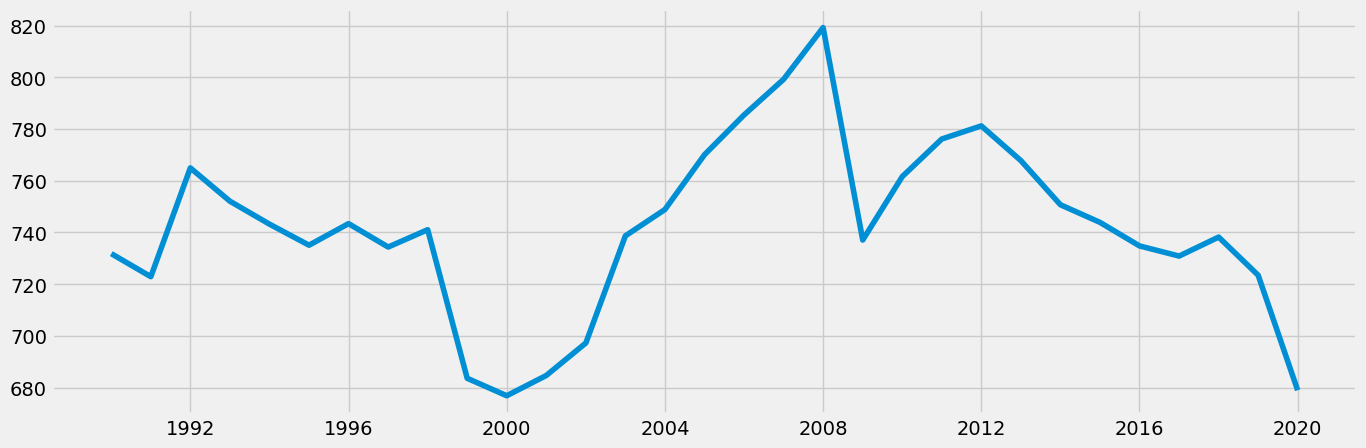

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub_unique)

### 3. Time series analysis: decomposition

In [16]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub_unique, model='additive')

In [17]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

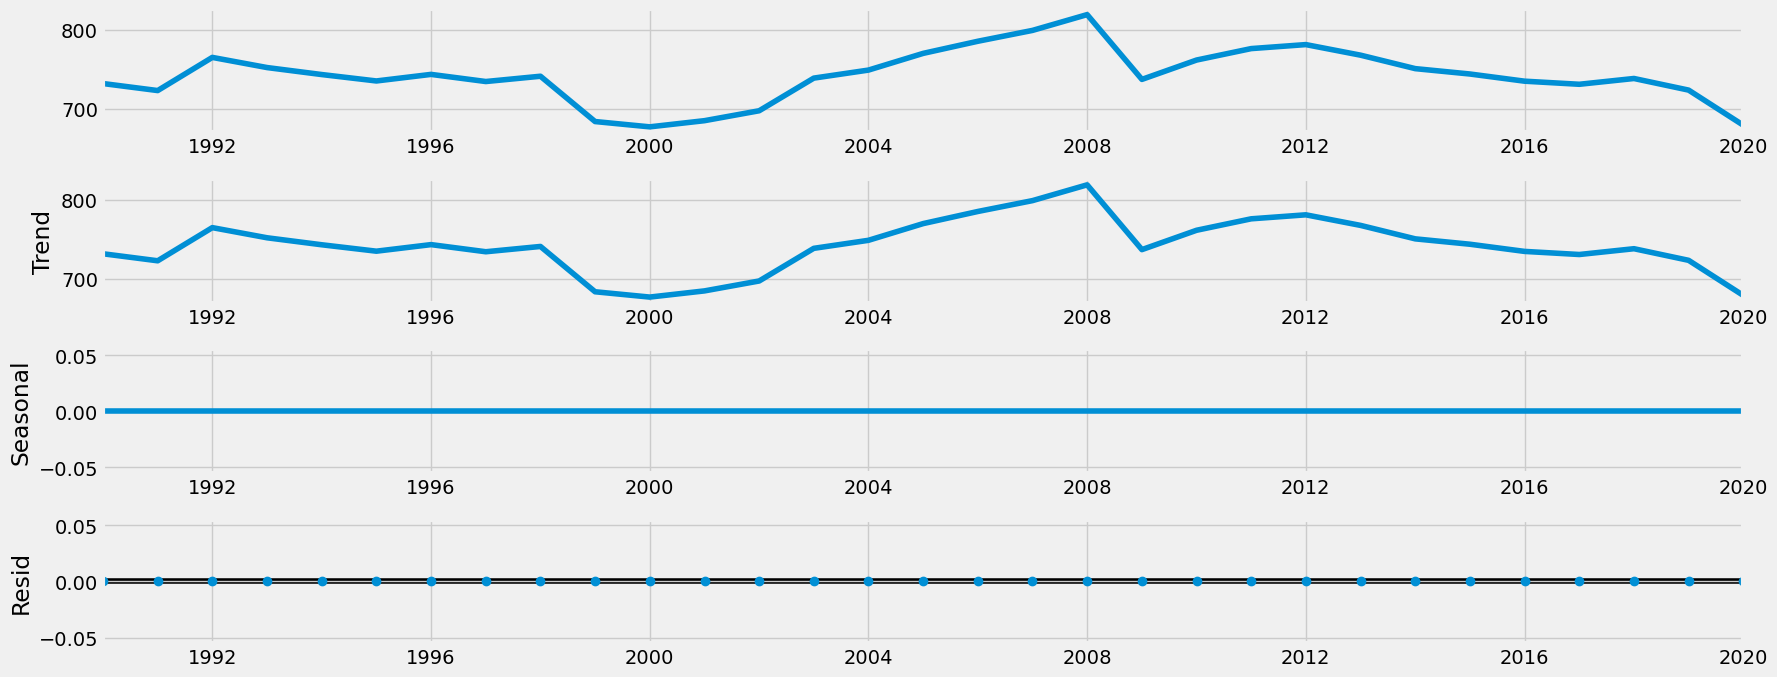

In [18]:
# Plot the separate components

decomposition.plot()
plt.show()

The level and trend are very similar, indicating that there is not much noise in the data. This can also be observed in the lack of residual below.

There is no seasonality in the data.

### 4. Testing for stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub_unique['total_co2_consumption'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.770521
p-value                         0.395192
Number of Lags Used             0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


The p-value of 0.4 is well above a relevant result, which would have to be below 0.05.

The critical value (5%) of -2.96 is below the test statistic of -1.77, which means that we cannot reject the null hypothesis. This means that the data is non-stationary.

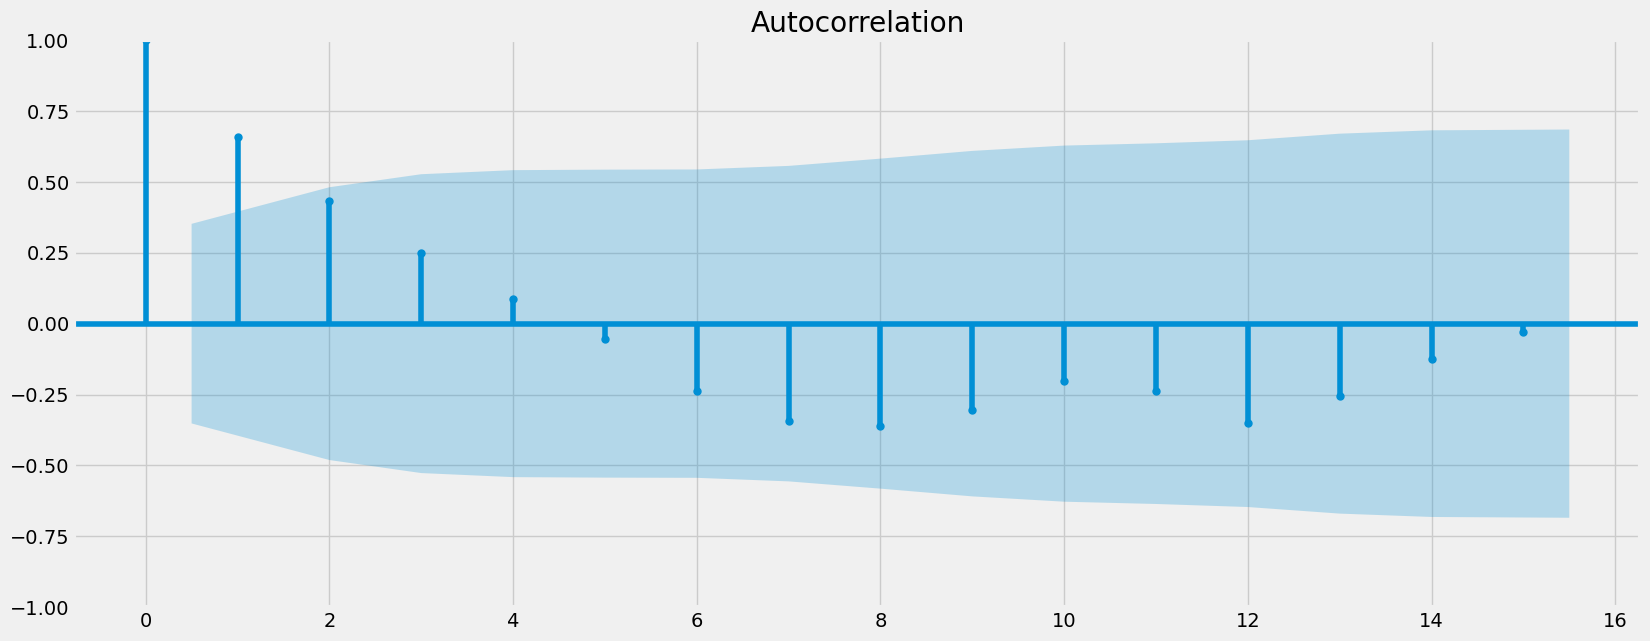

In [20]:
# Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub_unique)
plt.show()

With most values within the confidence interval, indicating that lags are not significantly correlated with each other. In addition, here again we can observe that the data is non-stationary. 

### 5. Stationarizing the CO2 consumption data

In [21]:
data_diff = df_sub_unique - df_sub_unique.shift(1)

In [22]:
# Remove the missing values resulting from the differencing

data_diff.dropna(inplace = True)

In [23]:
data_diff.head()

,total_co2_consumption
datetime,
1991-01-01,-8.902143
1992-01-01,42.043355
1993-01-01,-12.881806
1994-01-01,-8.856936
1995-01-01,-8.132850


In [24]:
data_diff.columns

Index(['total_co2_consumption'], dtype='object')

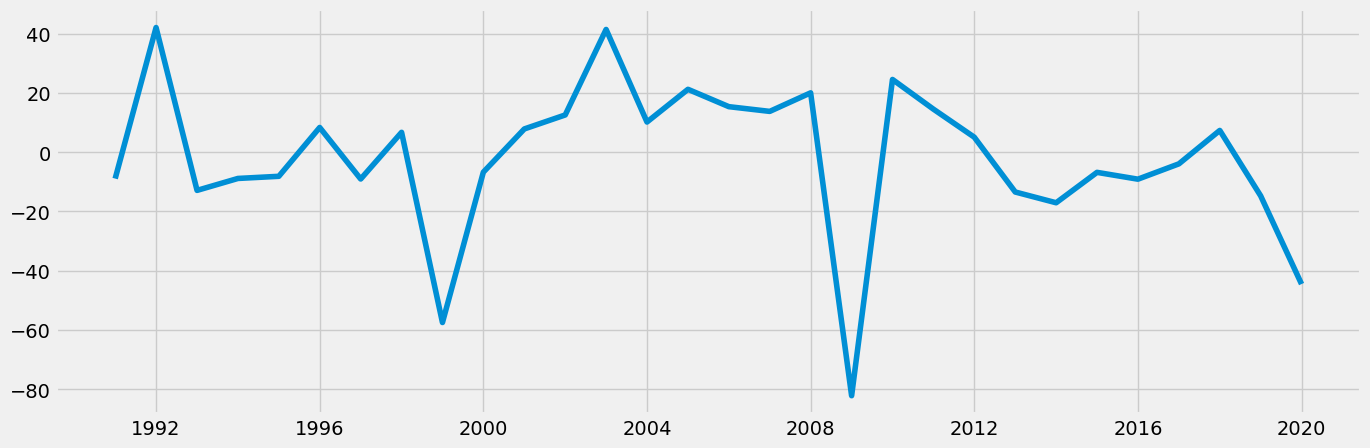

In [25]:
# Visualizing the time-series curve after the differencing 

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -5.313578
p-value                         0.000005
Number of Lags Used             0.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


The p-value is now well within statistical relevance (0.05) at 0.000005.

The test statistic is now smaller than the test statistic at both the 5 and 10 percent significance levels. We can thus reject the null hypothesis and confirm that the series is stationary.

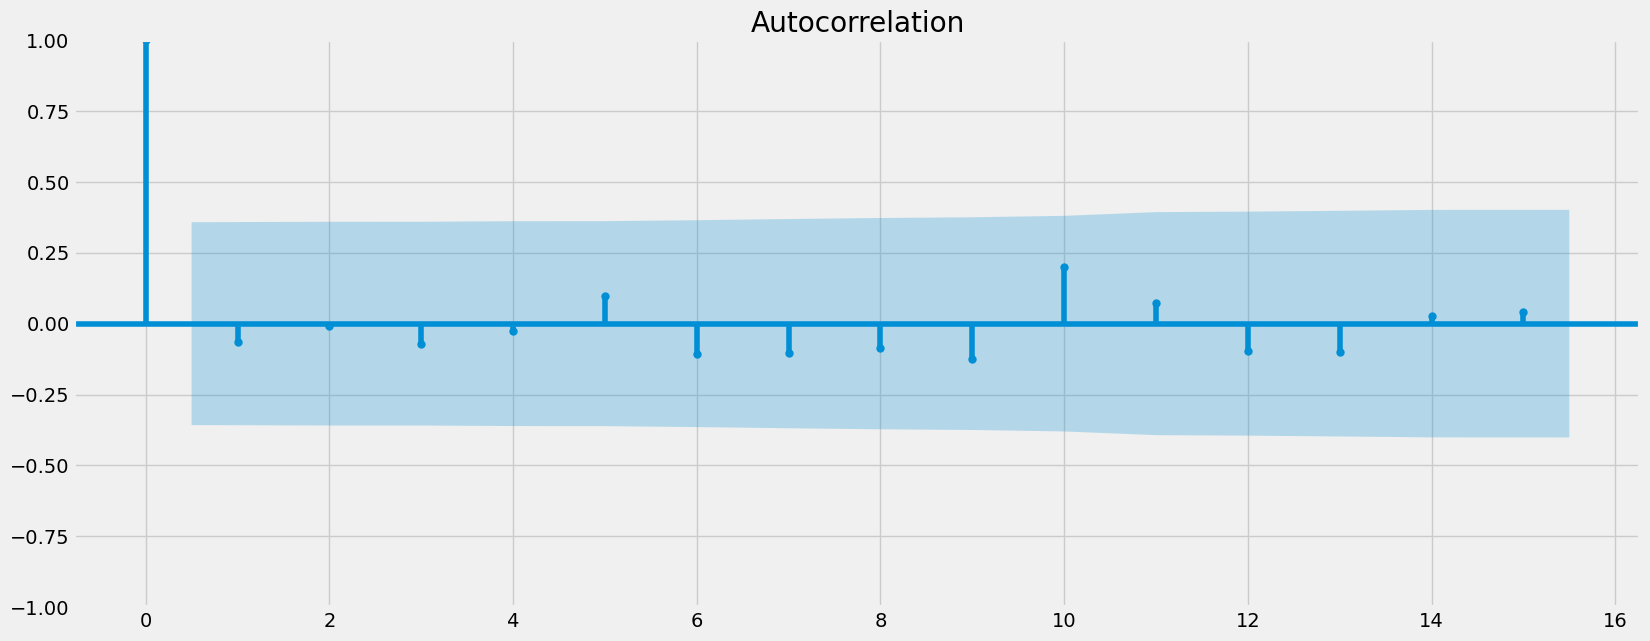

In [27]:
plot_acf(data_diff)
plt.show()